<h1>Raster Fairy - optional random swapping optimization</h1>
<p>Version 1.02<br/>Author: Mario Klingemann | @Quasimondo</p>
<p>Whilst Raster Fairy is very flexible with the variety of arrangements it can generate and also shows good performance even with big datasets it usually does not find the optimum arrangement that matrix-based methods like the Hungarian Algorithm can give you. Matrix-based methods on the other hand might be limited to square grids, can suffer from numerical issues and memory issues with big sets.</p>
<p>This demo uses several techniques by Kyle McDonald who's <a href="https://github.com/kylemcdonald/CloudToGrid">CloudToGrid</a> repository you should check out if you are looking for a good Hungarian based solution</p>
<p>As an optional step Raster Fairy offers a SwapOptimizer class which uses an evolutionary process to improve the arrangement iteratively. It can even be used standalone and given enough iterations will also converge on a near-optimal arrangement starting from a random arrangement.</p>
<p>In this demo I will show you how to use the SwapOptimizer class. As usual we start by creating an example dataset consisting of random RGB points and calculate a 2D t-sne embedding from it.</p>

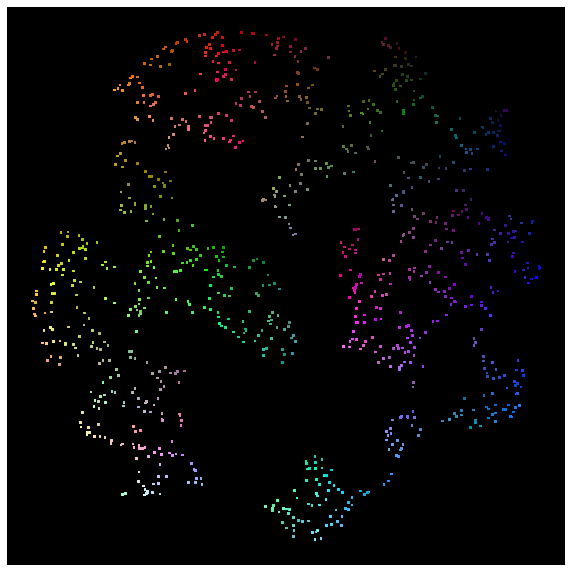

In [1]:
# just some basic setup for the purpose of this demo:
%matplotlib inline  
from IPython.display import display
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

from tsne import bh_sne
import numpy as np

# generate a set of 1024 random 3D points
totalDataPoints = 1024 
dataPoints = np.random.uniform(low=0.0, high=1.0, size=(totalDataPoints,3))

# create a t-sne embedding in 2D (we have to clone the array since bh_sne changes the original data)
# The bh_sne repository can be found here: https://github.com/danielfrg/tsne
xy = bh_sne(dataPoints.copy())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(xy[:,0],xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=7.5)    
plt.show()


Now we use Raster Fairy to generate a square grid from the cloud. Notice the warning message for the arrangements. The reason for this is that 1024 equals 2x2x2x2x2x2x2x2x2x2 which results in 10! = 3.628.800 possible permutations. And even though all permutations would be the same, the permutation class is not yet smart enough to see that in advance. So what it does in this case is to group all identical prime factors and only create permutations for the groups. This process might be improved in the future.

not enough memory for amount of possible permutations, creating grouped set
[(32, 32), (16, 64), (8, 128), (4, 256), (2, 512), (1, 1024)]


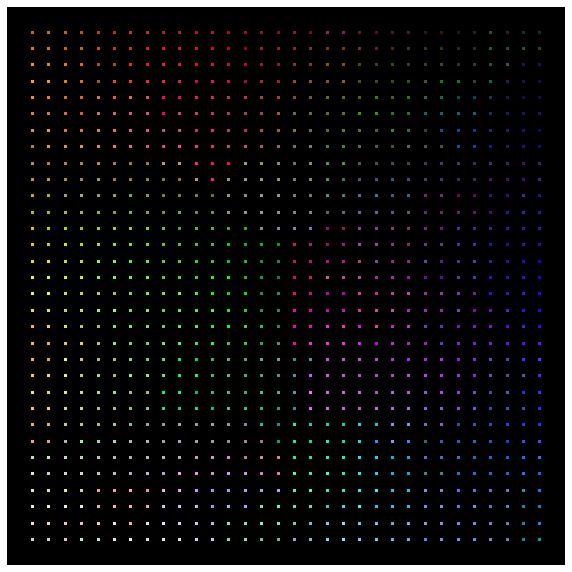

In [2]:
import rasterfairy

arrangements = rasterfairy.getRectArrangements(totalDataPoints)

print arrangements
grid_xy = rasterfairy.transformPointCloud2D(xy,target=arrangements[0])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(grid_xy[:,0],grid_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

This does not look too shabby, but the SwapOptimzier class can be used to further improve the result. It tries to optimize the arrangement so that the total travel distance of all original points to their final grid destination becomes minimal.

In [4]:
import rfoptimizer

optimizer = rfoptimizer.SwapOptimizer()

#since we used an arrangement we get the width and height of the grid from there
width, height = arrangements[0]

#if you used a raster mask instead you'd take the width and height from its metadata like this:
#width = rasterMask['width']
#height = rasterMask['height']

iterations = 100000
swapTable = optimizer.optimize(xy, grid_xy,width,height,iterations)


Starting sum of distances 9.9993463066
80000 9.44308571043
81000 9.44124628254
82000 9.43454263533
83000 9.43375857087
84000 9.43172125557
85000 9.4279958108
86000 9.42253376749
87000 9.42130136688
88000 9.41600458945
89000 9.4152090418
90000 9.41040968671
91000 9.40967073436
92000 9.40318597813
93000 9.40268142304
94000 9.39072052651
95000 9.39008519392
96000 9.39008519392
97000 9.388167313
98000 9.3867994526
99000 9.38494324427
improvement: 0.616150685342


If you want to see how the found improvement looks you use the returned list of indices to get a newly ordered set of grid points from the originally returned grid:

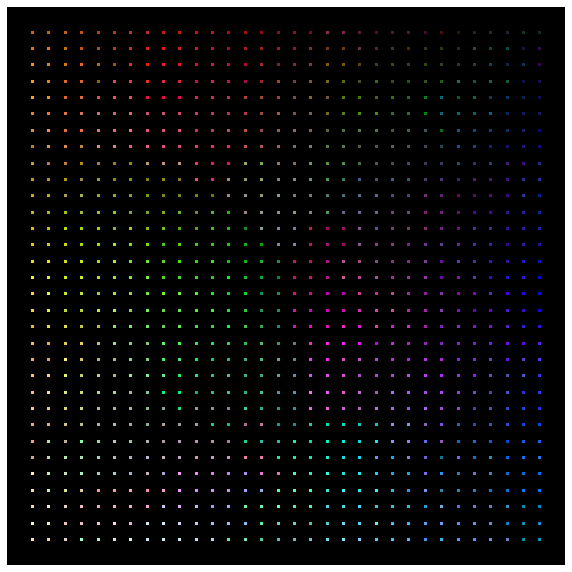

In [5]:
optimized_xy = grid_xy[swapTable]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

You can see if the swapping results in any further improvements by watching the progress report. If the final improvement is bigger that 0.0 that usually means that further improvement is possible. To continue from the last state of optimization you can use the continueOptimization() method, note that if you called the optimize again with the same arguments it would restart from the original grid and not continue.

Starting sum of distances 9.38319562126
80000 9.21981182928
81000 9.21981182928
82000 9.21981182928
83000 9.21666214391
84000 9.21598226554
85000 9.21598226554
86000 9.21598226554
87000 9.21535801462
88000 9.21535801462
89000 9.21019952647
90000 9.20641569101
91000 9.20641569101
92000 9.20496069663
93000 9.20417800037
94000 9.20409790687
95000 9.20409790687
96000 9.20389549056
97000 9.20389549056
98000 9.20217433892
99000 9.20137158438
improvement: 0.182749622014


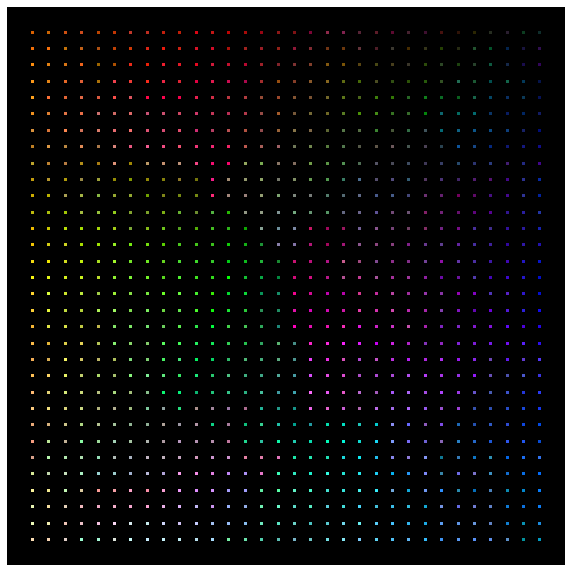

In [6]:
swapTable = optimizer.continueOptimization(100000)

optimized_xy = grid_xy[swapTable]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

At some point the improvements will usually stall and the arrangement has reached a point where it is very unlikely that the swapping will find a better solution. Still it is possible that the found result is just a local optimum. In order to get out of this optimum what is required is to stir up the arrangement a bit more, so it temporarily gets worse and then let the optimizer try to find a better solution than before. I've called this process "shaking" since you could see the grid like a play board with little balls and holes where every ball settles in a hole - and now imagine the stir up like picking up the board and giving it a bit of a shake or a whack :-).

This process is usually called "simulated annealing" and often results in small improvements. It's important though to give the optimizer enough iterations to recuperate from the disturbance. Otherwise, if it did not find a better solution in the given amount of iterations it will revert to the previously found best arrangement. Of course you can always try again and hope that the shaking happens at the right places.

Starting sum of distances 9.20044599924
80000 9.13073395609
81000 9.13044519814
82000 9.13025294228
83000 9.13025294228
84000 9.13025294228
85000 9.13013302396
86000 9.12969075149
87000 9.12969075149
88000 9.12921768322
89000 9.12921768322
90000 9.12917793953
91000 9.12911473216
92000 9.1273883109
93000 9.12675283164
94000 9.12675283164
95000 9.12501020009
96000 9.12501020009
97000 9.12494943566
98000 9.12494943566
99000 9.12494943566
improvement: 0.0756684143904


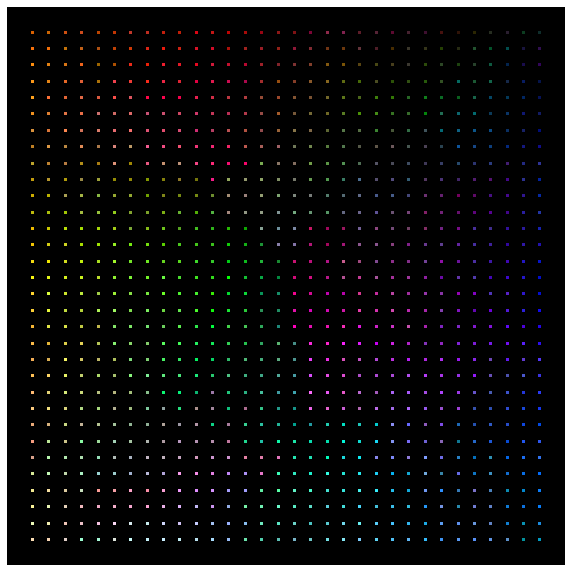

In [7]:
swapTable = optimizer.continueOptimization(100000,shakeIterations=5)

optimized_xy = grid_xy[swapTable]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

To see what how the original cloud maps to the grid and what kind of changes the swap optimizer has made you can use these debug views:

total iterations: 300000


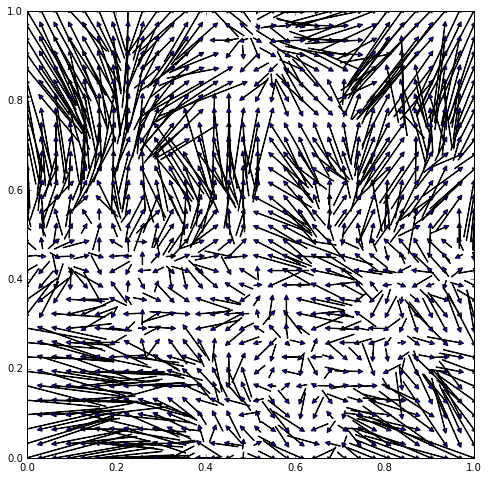

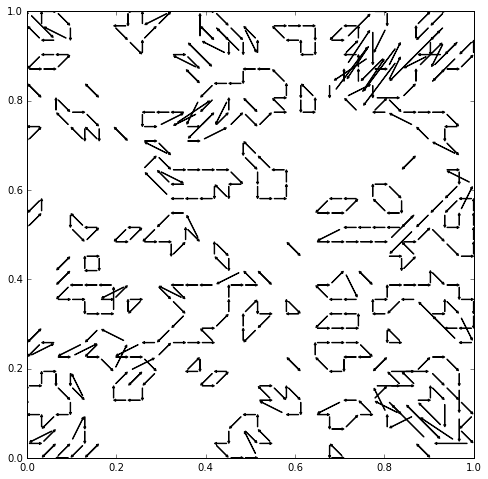

In [8]:
print "total iterations:", optimizer.lastState['iterations']

norm_grid_xy = optimizer.grid_norm
norm_optimized_grid_xy = norm_grid_xy[swapTable]
norm_xy = optimizer.xy_norm

plt.figure(figsize=(8, 8))
for start, end in zip(norm_xy, norm_optimized_grid_xy):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

plt.figure(figsize=(8, 8))
for end_rf, end_opt in zip(norm_grid_xy, norm_optimized_grid_xy):
    l = ( end_opt[0] - end_rf[0])*( end_opt[0] - end_rf[0]) + (end_opt[1] - end_rf[1])*(end_opt[1] - end_rf[1])
    if l > 0.0001:
        plt.arrow(end_rf[0] + (end_opt[0] - end_rf[0])*0.15, end_rf[1] + (end_opt[1] - end_rf[1])*0.15, (end_opt[0] - end_rf[0])*0.7, (end_opt[1] - end_rf[1])*0.7,
                  head_length=0.005, head_width=0.005, color='black')
    
plt.show()


As mentioned above you can even use the swap optimizer to find a near optimum solution for an entirely random arrangement. But you will have to give it enough iterations to do so. So let's shuffle the swap table first:

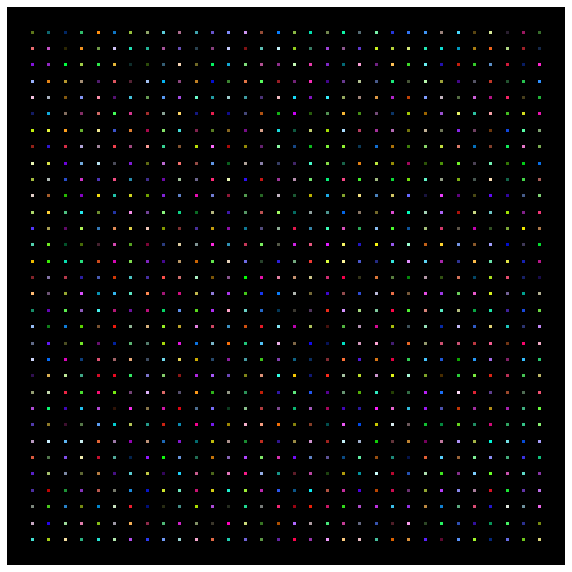

In [9]:
np.random.shuffle(swapTable)
shuffled_xy = grid_xy[swapTable]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(shuffled_xy[:,0],shuffled_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

In [10]:
iterations = 100000 #let first see how far 100.000 will get us
swapTable = optimizer.optimize(xy, grid_xy,width,height,iterations,swapTable=swapTable)

Starting sum of distances 321.162231889
80000 31.9303048856
81000 31.2951930912
82000 30.8649875905
83000 30.0972501027
84000 29.4832063588
85000 29.0374602922
86000 28.4761129701
87000 28.0727410632
88000 27.6523670047
89000 27.1903463843
90000 26.3677962453
91000 25.8895658381
92000 25.5453534736
93000 25.1857404628
94000 24.7846884045
95000 24.3972960291
96000 23.9984495615
97000 23.7175054604
98000 23.3620671146
99000 22.9487886411
improvement: 298.472228151


After 100.000 iterations we can already see some order emerging:

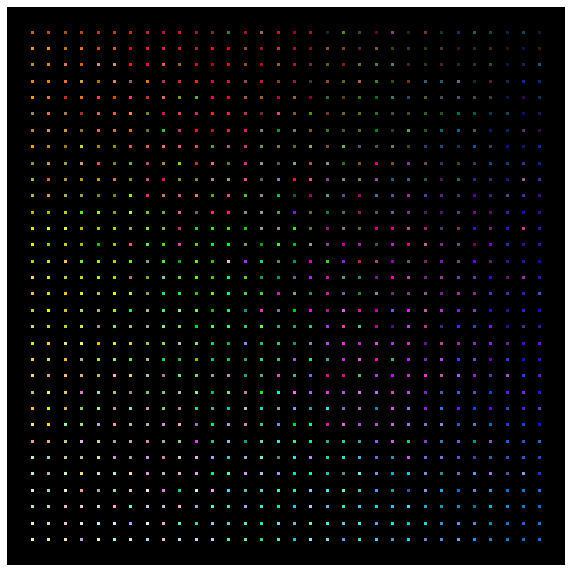

In [11]:
optimized_xy = grid_xy[swapTable]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

Let's continue the process for another million iterations:

Starting sum of distances 22.6900037386
980000 8.39273005079
981000 8.39273005079
982000 8.39273005079
983000 8.39263100924
984000 8.39263100924
985000 8.39263100924
986000 8.39260068837
987000 8.39260068837
988000 8.39167572733
989000 8.39167572733
990000 8.39167572733
991000 8.39167572733
992000 8.39167572733
993000 8.39167572733
994000 8.38942196443
995000 8.38942196443
996000 8.38839393281
997000 8.38780836106
998000 8.38780836106
999000 8.38780836106
improvement: 14.3029527307


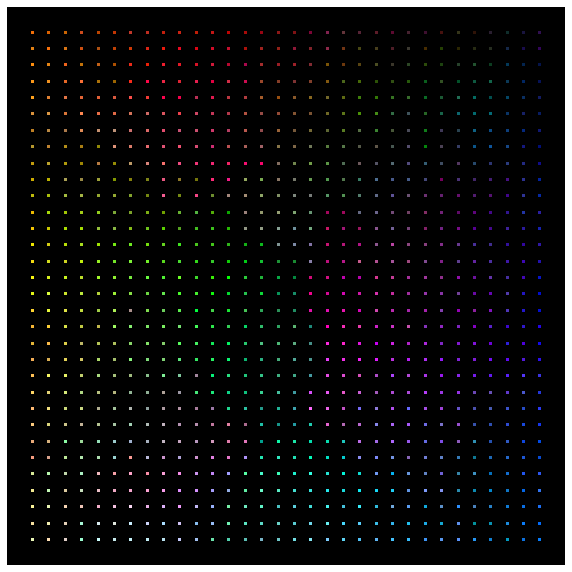

In [12]:
swapTable = optimizer.continueOptimization(1000000)

optimized_xy = grid_xy[swapTable]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

Now this is interesting - if you compare the best solution evolved from the original Raster Fairy arrangement and the one found from the random arrangement you see that the latter one is better! This is not totally surprising - the Raster Fairy solution could be seen as a very strong local optimum that is very hard to get out of whereas starting from the random state there are many more possible routes to get out of that fitness valley.

total iterations: 1400000


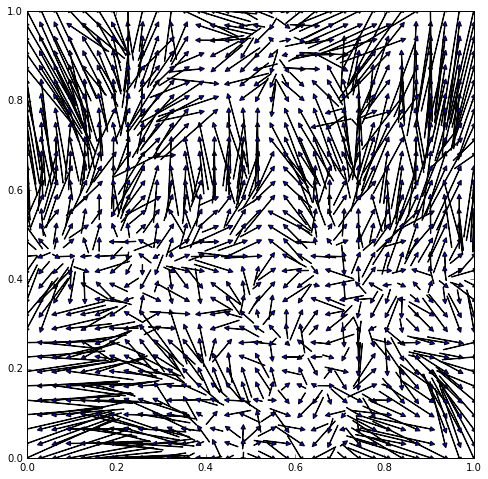

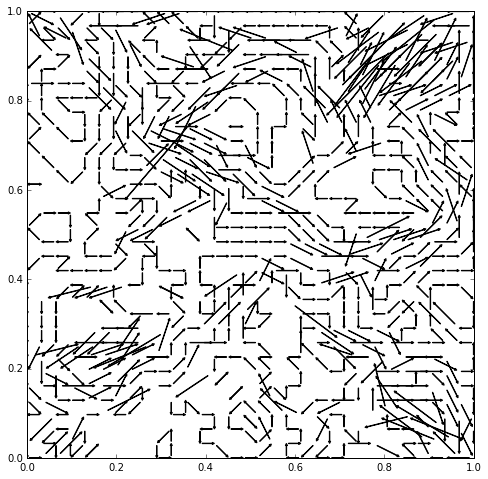

In [13]:
print "total iterations:", optimizer.lastState['iterations']

norm_grid_xy = optimizer.grid_norm
norm_optimized_grid_xy = norm_grid_xy[swapTable]
norm_xy = optimizer.xy_norm

plt.figure(figsize=(8, 8))
for start, end in zip(norm_xy, norm_optimized_grid_xy):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

plt.figure(figsize=(8, 8))
for end_rf, end_opt in zip(norm_grid_xy, norm_optimized_grid_xy):
    l = ( end_opt[0] - end_rf[0])*( end_opt[0] - end_rf[0]) + (end_opt[1] - end_rf[1])*(end_opt[1] - end_rf[1])
    if l > 0.0001:
        plt.arrow(end_rf[0] + (end_opt[0] - end_rf[0])*0.15, end_rf[1] + (end_opt[1] - end_rf[1])*0.15, (end_opt[0] - end_rf[0])*0.7, (end_opt[1] - end_rf[1])*0.7,
                  head_length=0.005, head_width=0.005, color='black')
    
plt.show()
